In [2]:
import pandas as pd
import gdown
from IPython.display import display

file_id = "1ImsvgsdvXTUZRE9lKDzXuexjWYIZbeQh"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "AAPL_stock.csv", quiet=False)


df = pd.read_csv("AAPL_stock.csv")

df = df.drop(0).reset_index(drop=True)

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    df[col] = df[col].astype(float)


df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

styled_df = df.head(10).style.background_gradient(cmap='viridis') \
                           .set_caption("Apple Inc. (AAPL) Stock Prices - First 10 Rows") \
                           .set_table_styles([{'selector': 'caption',
                                               'props': 'caption-side: top; font-size:16px; font-weight:bold; color:#4B0082;'}]) \
                           .format({'Open': '{:.2f}', 'High': '{:.2f}', 'Low': '{:.2f}', 'Close': '{:.2f}', 'Volume': '{:,.0f}'})

display(styled_df)


Downloading...
From: https://drive.google.com/uc?id=1ImsvgsdvXTUZRE9lKDzXuexjWYIZbeQh
To: /content/AAPL_stock.csv
100%|██████████| 120k/120k [00:00<00:00, 45.3MB/s]


,Date,Close,High,Low,Open,Volume
0,2020-06-04 00:00:00,78.33,79.13,77.96,78.83,"87,560,400"
1,2020-06-05 00:00:00,80.56,80.62,78.55,78.58,"137,250,400"
2,2020-06-08 00:00:00,81.04,81.07,79.54,80.26,"95,654,400"
3,2020-06-09 00:00:00,83.60,83.99,80.68,80.72,"147,712,400"
4,2020-06-10 00:00:00,85.75,86.22,84.11,84.55,"166,651,600"
5,2020-06-11 00:00:00,81.63,85.31,81.53,84.89,"201,662,400"
6,2020-06-12 00:00:00,82.33,84.52,81.22,83.77,"200,146,000"
7,2020-06-15 00:00:00,83.35,84.01,80.82,80.99,"138,808,800"
8,2020-06-16 00:00:00,85.56,85.83,83.77,85.41,"165,428,800"
9,2020-06-17 00:00:00,85.44,86.37,85.32,86.31,"114,406,400"


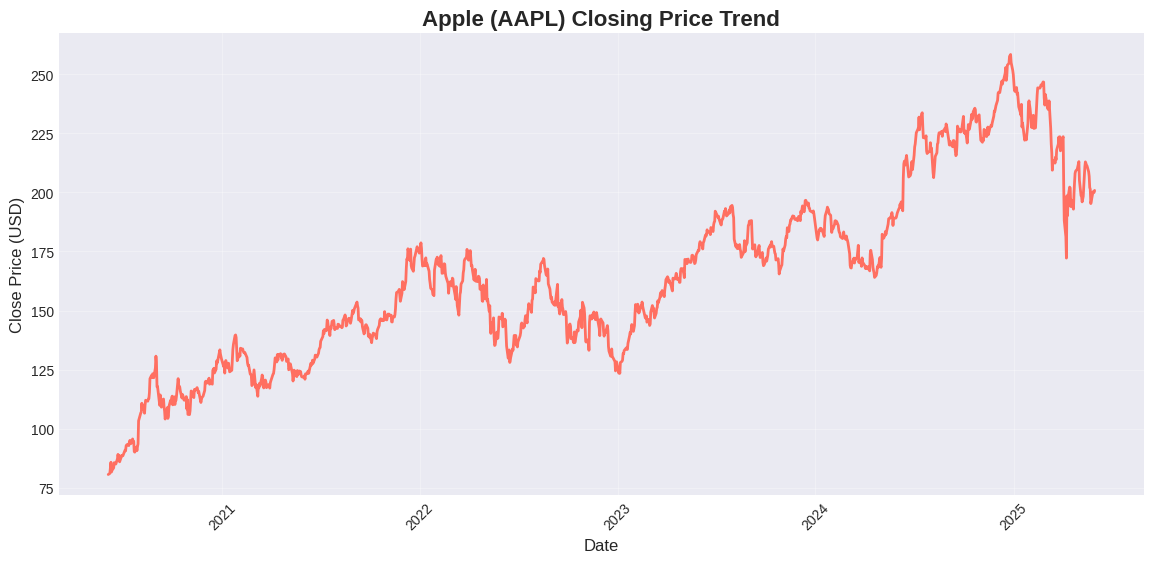

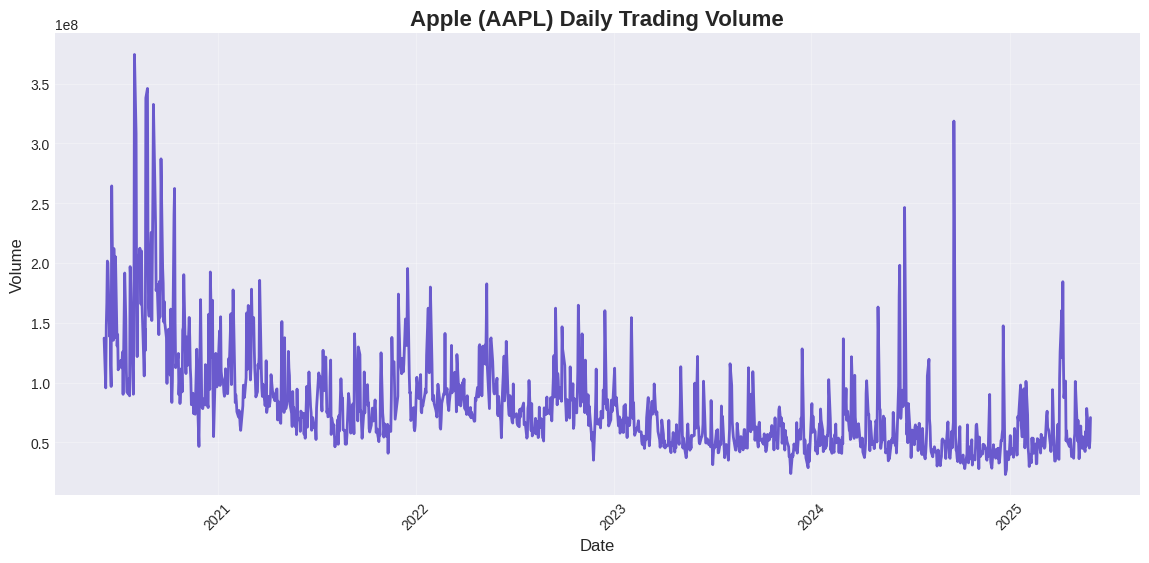

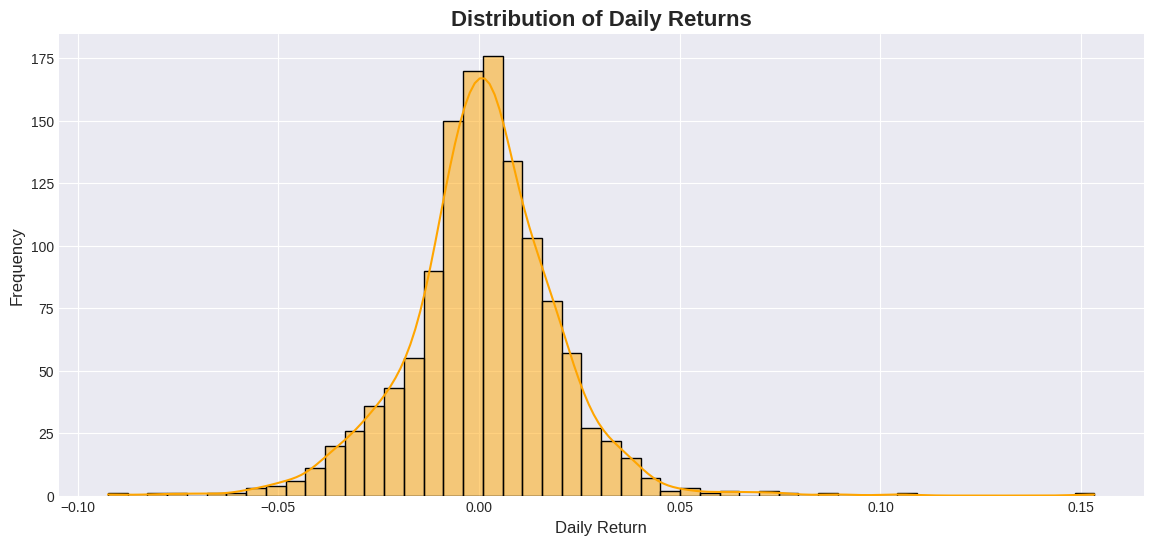

In [6]:
# ==========================================================
# STEP 02 — Exploratory Data Analysis (EDA) & Preprocessing
# ==========================================================

# ===================================
# STEP 02.1 — Visualize Stock Trends
# ===================================


import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("mako")
plt.rcParams['figure.figsize'] = (14,6)


plt.plot(df['Date'], df['Close'], color='#FF6F61', linewidth=2)
plt.title('Apple (AAPL) Closing Price Trend', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


plt.plot(df['Date'], df['Volume'], color='#6A5ACD', linewidth=2)
plt.title('Apple (AAPL) Daily Trading Volume', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


df['Daily_Return'] = df['Close'].pct_change()
sns.histplot(df['Daily_Return'].dropna(), bins=50, kde=True, color='#FFA500')
plt.title('Distribution of Daily Returns', fontsize=16, weight='bold')
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


In [7]:
# ==========================================================
# STEP 02 — Exploratory Data Analysis (EDA) & Preprocessing
# ==========================================================

# ==========================================
# STEP 02.2 — Preprocess Data for Modeling
# ==========================================


df['Next_Close'] = df['Close'].shift(-1)


df = df.dropna().reset_index(drop=True)


X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Next_Close']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# =====================================
# STEP 03 — Model Selection & Training
# =====================================

# ==========================================
# STEP 03.1 — Train Linear Regression Model
# ==========================================


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression R² Score: {r2:.4f}")




Linear Regression RMSE: 4.43
Linear Regression R² Score: 0.9180


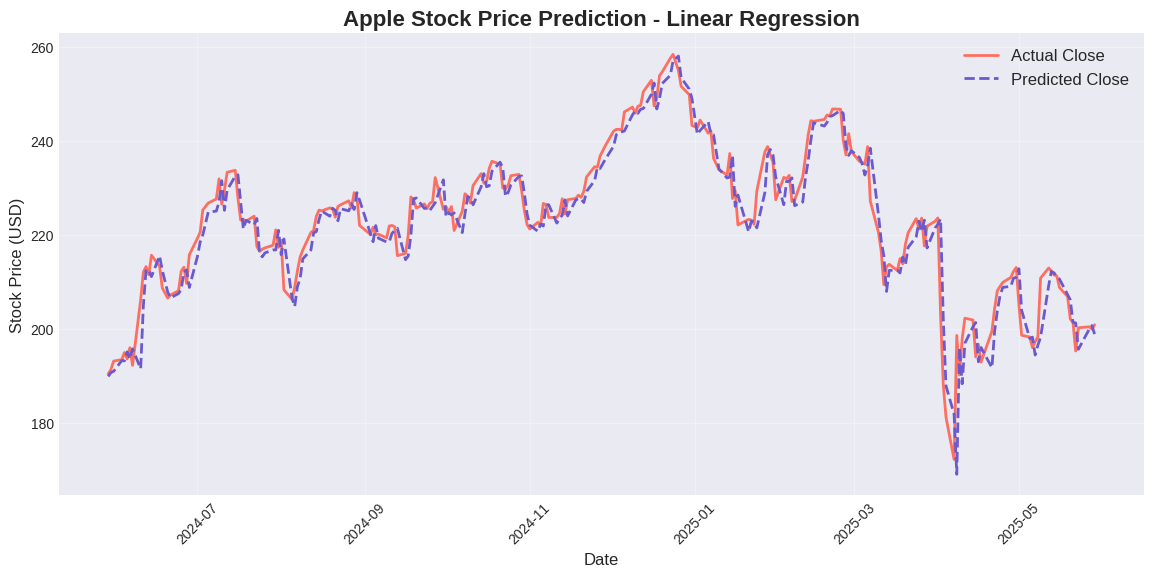

In [10]:
# =====================================
# STEP 03 — Model Selection & Training
# =====================================

# ==================================
# STEP 03.2 — Visualize Predictions
# ==================================


import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual Close', color='#FF6F61', linewidth=2)
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted Close', color='#6A5ACD', linewidth=2, linestyle='--')
plt.title('Apple Stock Price Prediction - Linear Regression', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [11]:
# ======================================
# STEP 04 — Advanced Modeling with LSTM
# ======================================

# ==================================
# STEP 04.1 — Prepare Data for LSTM
# ==================================

import numpy as np
from sklearn.preprocessing import MinMaxScaler


data = df[['Close']].values


scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)


time_step = 60

X_lstm = []
y_lstm = []

for i in range(time_step, len(scaled_data)):
    X_lstm.append(scaled_data[i-time_step:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)


X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))


train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]


In [12]:
# ======================================
# STEP 04 — Advanced Modeling with LSTM
# ======================================

# ==============================
# STEP 04.2 — Build LSTM Model
# ==============================


!pip install --upgrade tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ======================================
# STEP 04 — Advanced Modeling with LSTM
# ======================================

# ==============================
# STEP 04.3 — Train LSTM Model
# ==============================

history = model.fit(X_train_lstm, y_train_lstm,
                    epochs=50, batch_size=32,
                    validation_split=0.1, verbose=1)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 0.0508 - val_loss: 0.0017
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0020 - val_loss: 9.7292e-04
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - los

In [14]:
# ======================================
# STEP 04 — Advanced Modeling with LSTM
# ======================================

# ======================================
# STEP 04.4 — Predict and Inverse Scale
# ======================================


y_pred_lstm = model.predict(X_test_lstm)


y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm.reshape(-1,1))



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


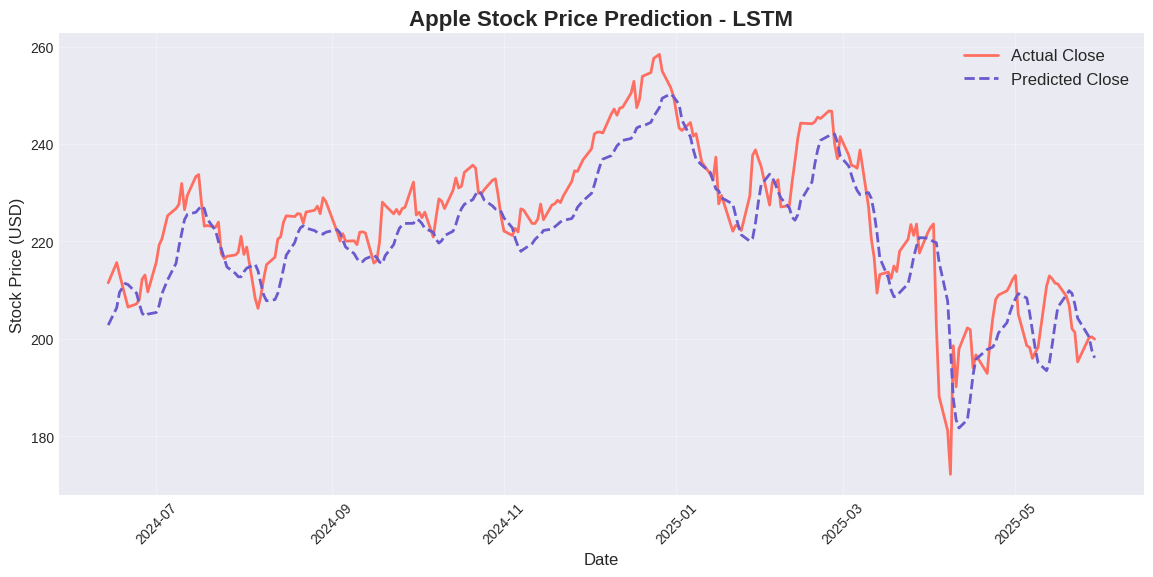

In [15]:
# ======================================
# STEP 04 — Advanced Modeling with LSTM
# ======================================

# =======================================
# STEP 04.5 — Visualize LSTM Predictions
# =======================================

plt.figure(figsize=(14,6))
plt.plot(df['Date'].iloc[-len(y_test_lstm_actual):], y_test_lstm_actual, label='Actual Close', color='#FF6F61', linewidth=2)
plt.plot(df['Date'].iloc[-len(y_test_lstm_actual):], y_pred_lstm, label='Predicted Close', color='#6A5ACD', linewidth=2, linestyle='--')
plt.title('Apple Stock Price Prediction - LSTM', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


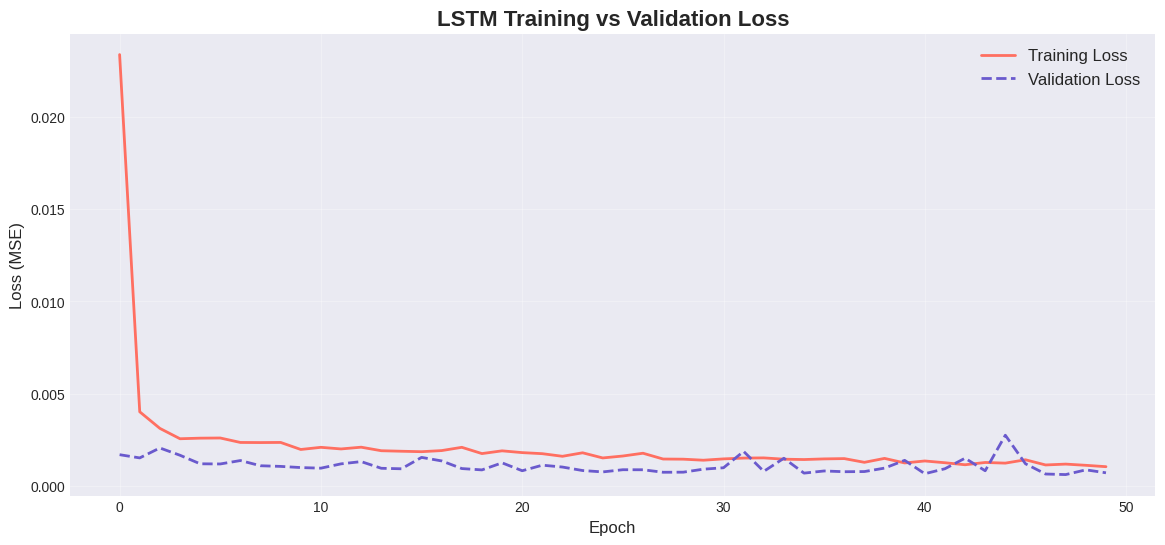

In [16]:
# ======================================
# STEP 04 — Advanced Modeling with LSTM
# ======================================

# ======================================================
# STEP 04.5 — Training vs Validation Loss Visualization
# ======================================================

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'], label='Training Loss', color='#FF6F61', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#6A5ACD', linewidth=2, linestyle='--')
plt.title('LSTM Training vs Validation Loss', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [17]:
# ====================================================
# STEP 05 — Model Evaluation Metrics & Error Analysis
# ====================================================

# ==============================================
# STEP 05.1 — Evaluation for Linear Regression
# ==============================================

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))

mae_lr = mean_absolute_error(y_test, y_pred)

mape_lr = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"MAPE: {mape_lr:.2f}%")



Linear Regression Performance:
RMSE: 4.43
MAE: 3.06
MAPE: 1.40%


In [18]:
# ====================================================
# STEP 05 — Model Evaluation Metrics & Error Analysis
# ====================================================

# ================================
# STEP 05.2 — Evaluation for LSTM
# ================================

rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_actual, y_pred_lstm))

mae_lstm = mean_absolute_error(y_test_lstm_actual, y_pred_lstm)

mape_lstm = np.mean(np.abs((y_test_lstm_actual - y_pred_lstm) / y_test_lstm_actual)) * 100

print("\nLSTM Performance:")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE: {mae_lstm:.2f}")
print(f"MAPE: {mape_lstm:.2f}%")




LSTM Performance:
RMSE: 7.50
MAE: 5.94
MAPE: 2.69%


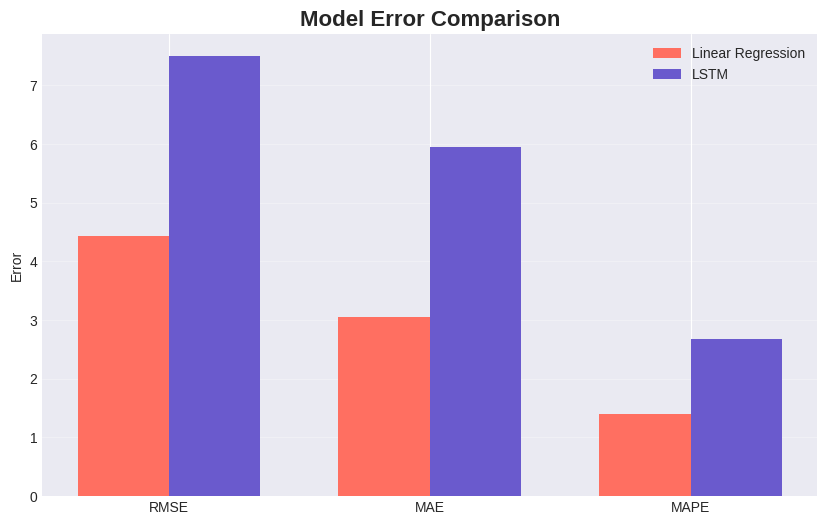

In [19]:
# ====================================================
# STEP 05 — Model Evaluation Metrics & Error Analysis
# ====================================================

# ========================================
# STEP 05.3 — Visual Comparison of Errors
# ========================================

import matplotlib.pyplot as plt

metrics = ['RMSE', 'MAE', 'MAPE']
lr_scores = [rmse_lr, mae_lr, mape_lr]
lstm_scores = [rmse_lstm, mae_lstm, mape_lstm]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, lr_scores, width, label='Linear Regression', color='#FF6F61')
plt.bar(x + width/2, lstm_scores, width, label='LSTM', color='#6A5ACD')
plt.ylabel('Error')
plt.title('Model Error Comparison', fontsize=16, weight='bold')
plt.xticks(x, metrics)
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━

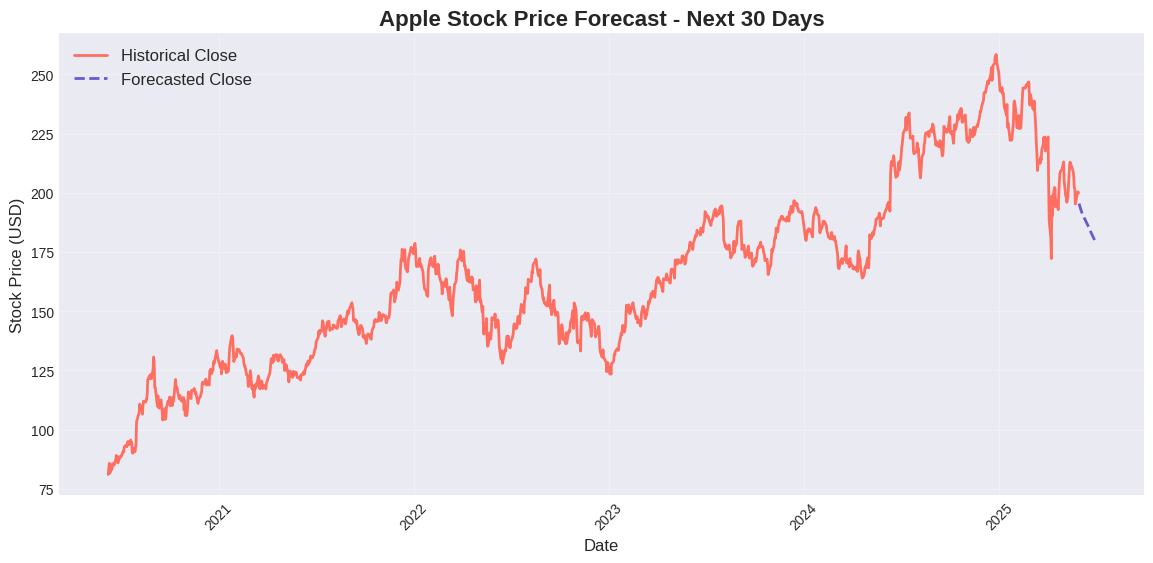

In [20]:
# =====================================================================
# STEP 06 — Future Stock Price Forecasting using the trained LSTM model
# =====================================================================


import numpy as np
import matplotlib.pyplot as plt

future_days = 30

last_60_days = scaled_data[-60:]
forecast_input = last_60_days.reshape(1, -1)  # shape (1,60)
forecast_input = np.copy(forecast_input)

predictions = []

for _ in range(future_days):
    X_forecast = forecast_input.reshape((1, 60, 1))
    next_pred = model.predict(X_forecast)
    predictions.append(next_pred[0,0])

    forecast_input = np.append(forecast_input[:,1:], next_pred, axis=1)


predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1,1))


last_date = df['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(future_days)]

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Historical Close', color='#FF6F61', linewidth=2)
plt.plot(future_dates, predicted_prices, label='Forecasted Close', color='#6A5ACD', linewidth=2, linestyle='--')
plt.title(f'Apple Stock Price Forecast - Next {future_days} Days', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()



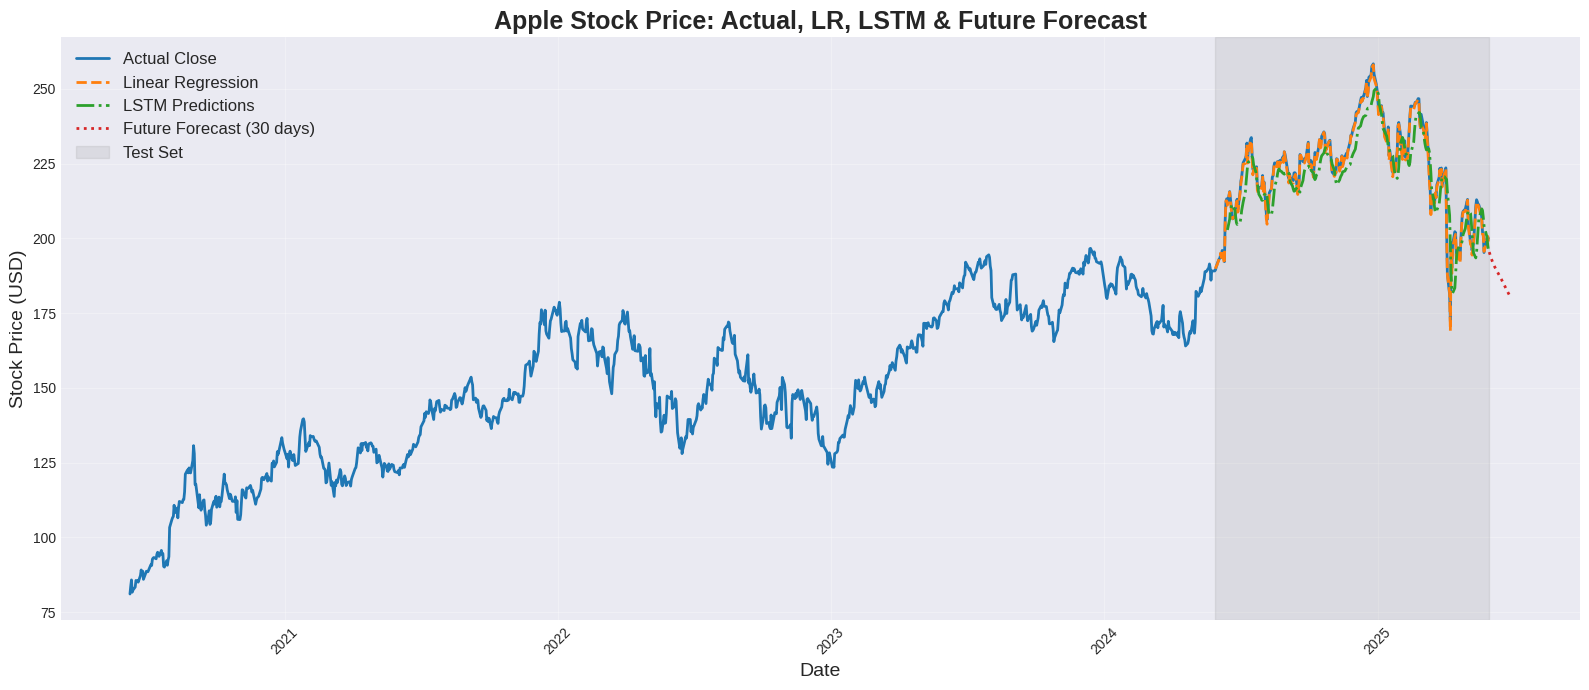

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))

# Historical Actual Close
plt.plot(df['Date'], df['Close'], label='Actual Close', color='#1f77b4', linewidth=2)

# Linear Regression predictions (test period)
plt.plot(df['Date'].iloc[-len(y_test):], y_pred,
         label='Linear Regression', color='#ff7f0e', linewidth=2, linestyle='--')

# LSTM predictions (test period)
plt.plot(df['Date'].iloc[-len(y_test_lstm_actual):], y_pred_lstm.flatten(),
         label='LSTM Predictions', color='#2ca02c', linewidth=2, linestyle='-.')

# Future forecast
plt.plot(future_dates, predicted_prices.flatten(),
         label=f'Future Forecast ({len(future_dates)} days)', color='#d62728', linewidth=2, linestyle=':')


plt.axvspan(df['Date'].iloc[-len(y_test)], df['Date'].iloc[-1], color='grey', alpha=0.15, label='Test Set')

plt.title('Apple Stock Price: Actual, LR, LSTM & Future Forecast', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price (USD)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()
